# Data Cleaning and Target Engineering

Author: Cooper Lindstrom

Description: This notebook performs data cleaning and preprocessing on PharmGKB variant-drug-phenotype data. It ensures the dataset is standardized, removes duplicates, handles missing values, and prepares a binary target variable for modeling.

## Set up the Environment

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configure visual style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

### Load and Inspect the Dataset

Load the PharmGKB clinical variant-drug data. (https://www.clinpgx.org/downloads) 

In [16]:
# Load the TSV file
df = pd.read_csv("clinical_variants.tsv", sep="\t")

# Display basic info and first few rows
print("Initial shape:", df.shape)
df.info()
df.head()

Initial shape: (5190, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5190 entries, 0 to 5189
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   variant            5190 non-null   object
 1   gene               4936 non-null   object
 2   type               5190 non-null   object
 3   level of evidence  5190 non-null   object
 4   chemicals          5190 non-null   object
 5   phenotypes         4176 non-null   object
dtypes: object(6)
memory usage: 243.4+ KB


,variant,gene,type,level of evidence,chemicals,phenotypes
0,"CYP2C9*1, CYP2C9*3, CYP2C9*13",CYP2C9,Metabolism/PK,1A,lornoxicam,NaN
1,"CYP2C9*1, CYP2C9*2, CYP2C9*3",CYP2C9,Metabolism/PK,1A,siponimod,NaN
2,rs17376848,DPYD,Toxicity,1A,capecitabine,Neoplasms
3,rs2297595,DPYD,Toxicity,1A,capecitabine,Neoplasms
4,rs1801265,DPYD,Toxicity,1A,capecitabine,Neoplasms


### Clean Column Names and Standardize Strings

In [17]:
# Remove leading/trailing whitespace in column names
df.columns = df.columns.str.strip()

# Clean string columns
string_cols = ['variant', 'gene', 'type', 'level of evidence', 'chemicals', 'phenotypes']
for col in string_cols:
    df[col] = df[col].astype(str).str.strip()

### Handle Missing Data

Variants and chemicals are critical for analysis, so I removed rows missing these.

I kept missing gene info by labeling them as "Unknown" to preserve data volume.

In [18]:
# Drop rows missing essential fields (variant or chemical)
df = df.dropna(subset=['variant', 'chemicals'])
print("After dropping rows missing variant or chemical:", df.shape)

# Fill missing genes with 'Unknown'
df['gene'] = df['gene'].replace('nan', np.nan).fillna('Unknown')

# Confirm missing values
df.isna().sum()

After dropping rows missing variant or chemical: (5190, 6)


variant              0
gene                 0
type                 0
level of evidence    0
chemicals            0
phenotypes           0
dtype: int64

### Remove Duplicates

Duplicates often occur when multiple annotations describe the same variant-drug pair. Removing them ensures each record is unique.

In [19]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")

Removed 21 duplicate rows.


### Create Target Variable

This binary target distinguishes between entries that have phenotype annotations (e.g., adverse effects, responses) versus those that do not, essential for supervised learning later.

In [23]:
# Convert string 'nan' (and similar) to actual np.nan
df['phenotypes'] = df['phenotypes'].replace(['nan', 'NaN', 'None', '', ' '], np.nan)

# Create binary target: 1 = phenotype info present, 0 = missing phenotype
df['phenotype_present'] = df['phenotypes'].notna().astype(int)

print("\nTarget distribution:")
print(df['phenotype_present'].value_counts())


Target distribution:
phenotype_present
1    4163
0    1006
Name: count, dtype: int64


### Summary Statistics

This helps understand dataset diversity and complexity, e.g., how many drugs, genes, or evidence levels are represented.

In [25]:
print("Number of unique drugs:", df['chemicals'].nunique())
print("Number of unique variants:", df['variant'].nunique())
print("Number of unique genes:", df['gene'].nunique())
print("Number of unique evidence levels:", df['level of evidence'].nunique())

Number of unique drugs: 874
Number of unique variants: 3161
Number of unique genes: 1088
Number of unique evidence levels: 6


### Exploratory Visualizations

The **target distribution** shows a class imbalance (more phenotype-positive cases).

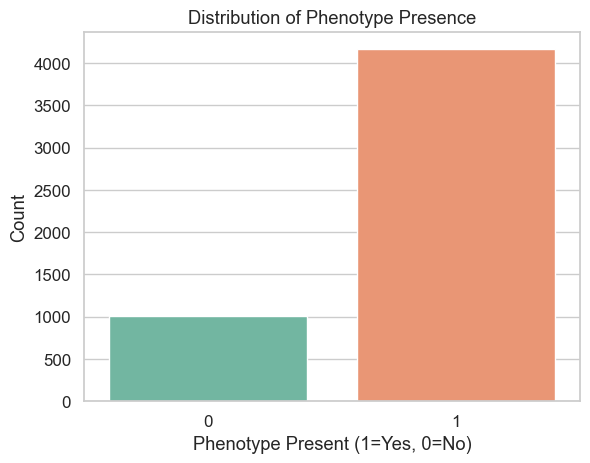

In [26]:
# Target distribution
sns.countplot(data=df, x='phenotype_present', hue='phenotype_present', palette='Set2', legend=False)
plt.title("Distribution of Phenotype Presence")
plt.xlabel("Phenotype Present (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()

The **evidence level** plot highlights which types of associations (1A, 2B, etc.) dominate.

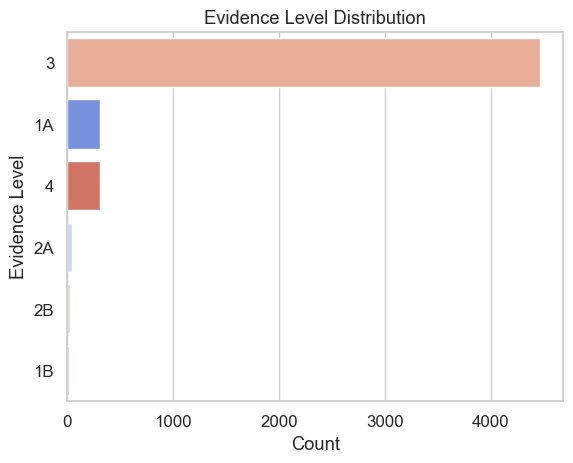

In [27]:
# Evidence level distribution
sns.countplot(data=df, y='level of evidence', hue='level of evidence', legend=False, 
              order=df['level of evidence'].value_counts().index, palette='coolwarm')
plt.title("Evidence Level Distribution")
plt.xlabel("Count")
plt.ylabel("Evidence Level")
plt.show()

The **top phenotypes** show which conditions are most frequently studied.

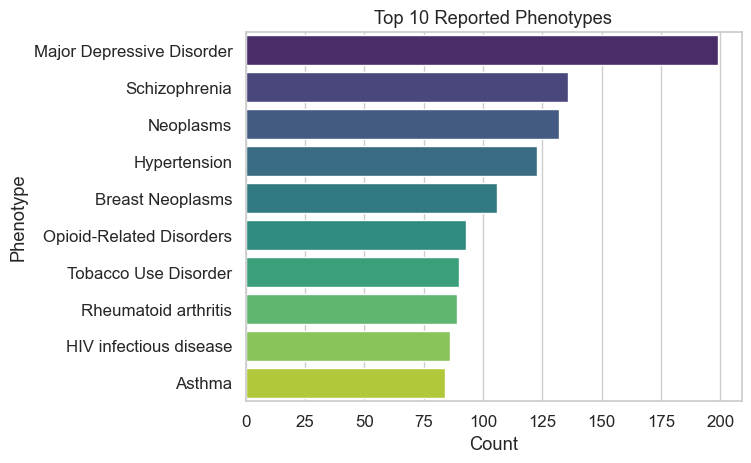

In [28]:
# Top 10 most frequent phenotypes
top_phenos = df['phenotypes'].value_counts().head(10)
sns.barplot(x=top_phenos.values, y=top_phenos.index, hue=top_phenos.index, palette='viridis', legend=False)
plt.title("Top 10 Reported Phenotypes")
plt.xlabel("Count")
plt.ylabel("Phenotype")
plt.show()

### Final Dataset Overview

The dataset is now clean, standardized, and ready for modeling or deeper analysis such as feature engineering or gene–drug clustering.

**Interpretation and Insights**

1. High Genetic Diversity (3,161 variants, 1,088 genes): The large number of unique genetic variants and genes suggests the dataset captures a wide range of biological diversity. This can be very valuable for studying complex genotype–phenotype relationships or drug response patterns.

    - It also indicates potential for rich feature spaces, which might require dimensionality reduction or feature selection to avoid overfitting in predictive models.

2. Moderate Drug Diversity (874 unique drugs): Having nearly 900 unique drugs implies the dataset spans a broad pharmacological landscape, possibly covering multiple therapeutic classes.

    - This supports analyses like drug repurposing, drug–gene interaction mapping, or drug efficacy prediction.

3. Evidence Level Variety (6 distinct levels): The six unique evidence levels likely correspond to different degrees of confidence or validation in the drug–gene or variant–phenotype associations.

    - For example, higher evidence levels may represent clinically validated relationships, while lower levels could be research-stage or predicted associations.
    - Understanding how evidence levels are distributed could help in weighing features or filtering unreliable associations.

4. Implied Data Complexity: Combining thousands of variants, over a thousand genes, and nearly a thousand drugs creates a complex many-to-many relationship network.

    - Each gene may interact with multiple drugs and variants.
    - This network structure makes it ideal for machine learning approaches like Random Forests, Gradient Boosting, or even graph-based models (e.g., knowledge graphs, GNNs).

In [30]:
print("\nFinal cleaned dataset shape:", df.shape)
df.head(10)


Final cleaned dataset shape: (5169, 7)


,variant,gene,type,level of evidence,chemicals,phenotypes,phenotype_present
0,"CYP2C9*1, CYP2C9*3, CYP2C9*13",CYP2C9,Metabolism/PK,1A,lornoxicam,NaN,0
1,"CYP2C9*1, CYP2C9*2, CYP2C9*3",CYP2C9,Metabolism/PK,1A,siponimod,NaN,0
2,rs17376848,DPYD,Toxicity,1A,capecitabine,Neoplasms,1
3,rs2297595,DPYD,Toxicity,1A,capecitabine,Neoplasms,1
4,rs1801265,DPYD,Toxicity,1A,capecitabine,Neoplasms,1
5,"CYP2C19*1, CYP2C19*2, CYP2C19*3",CYP2C19,Metabolism/PK,1A,dexlansoprazole,NaN,0
6,"CYP2C9*1, CYP2C9*2, CYP2C9*3, CYP2C9*5, CYP2C9...",CYP2C9,Toxicity,1A,warfarin,over-anticoagulation,1
7,rs1801160,DPYD,Toxicity,1A,capecitabine,Neoplasms,1
8,rs1801159,DPYD,Toxicity,1A,capecitabine,Neoplasms,1
9,"UGT1A1*1, UGT1A1*6, UGT1A1*28, UGT1A1*36, UGT1...",UGT1A1,Toxicity,1A,"atazanavir,atazanavir / ritonavir","HIV infectious disease,Hyperbilirubinemia",1


### Pre-Modeling Summary

This section provides an overview of the dataset after the cleaning and preprocessing steps.  
It confirms that the data is ready for feature engineering and model development.

Key questions addressed:
- What is the final dataset shape?
- How many unique entities exist for key columns (e.g., drugs, genes, variants)?
- What is the target distribution?
- Are there any remaining missing values?

This summary helps ensure data integrity before moving into the modeling phase.

In [35]:
# Display final dataset dimensions
print("Final Dataset Shape:", df.shape)

# Check remaining missing values
print("\nMissing Values Per Column:")
print(df.isna().sum())

# Key unique counts
print("\nUnique Counts:")
print(f"Number of unique drugs: {df['chemicals'].nunique()}")
print(f"Number of unique variants: {df['variant'].nunique()}")
print(f"Number of unique genes: {df['gene'].nunique()}")
print(f"Number of unique evidence levels: {df['level of evidence'].nunique()}")

# Target variable summary
print("\nTarget Distribution:")
print(df['phenotype_present'].value_counts())

# Quick data type check
print("\nData Types:")
print(df.dtypes)

Final Dataset Shape: (5169, 7)

Missing Values Per Column:
variant                 0
gene                    0
type                    0
level of evidence       0
chemicals               0
phenotypes           1006
phenotype_present       0
dtype: int64

Unique Counts:
Number of unique drugs: 874
Number of unique variants: 3161
Number of unique genes: 1088
Number of unique evidence levels: 6

Target Distribution:
phenotype_present
1    4163
0    1006
Name: count, dtype: int64

Data Types:
variant              object
gene                 object
type                 object
level of evidence    object
chemicals            object
phenotypes           object
phenotype_present     int64
dtype: object


**Summary Interpretation**

- The final dataset contains **5,169 observations and 7 columns**, all essential for modeling.  
- Only the `phenotypes` column has missing values (1,006 rows), which correspond to samples without recorded phenotype information.  
- The target variable `phenotype_present` has a **moderate class imbalance** (1: 4163, 0: 1006).  
- There are **874 unique drugs**, **3161 genetic variants**, and **1088 unique genes**, reflecting substantial biological diversity.  
- All features are properly typed (`object` for categorical, `int64` for the target variable).  
- No critical missing data remain, ensuring the dataset is ready for feature engineering and modeling.

**Next step:** proceed to `modeling.ipynb` to conduct the pre-modeling checklist and begin model development.

### Export Clean Dataset

After completing all data cleaning, transformations, and checks, we now export the clean dataset for modeling.  
This ensures the modeling notebook (`modeling.ipynb`) starts with a consistent, ready-to-use dataset.

In [37]:
# Verify final shape and columns before saving
print("Final Dataset Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

# Save clean dataset to CSV
clean_path = "cleaned_pharmacogenomics_data.csv"
df.to_csv(clean_path, index=False)

print(f"\nClean dataset successfully saved to: {clean_path}")

Final Dataset Shape: (5169, 7)

Columns:
['variant', 'gene', 'type', 'level of evidence', 'chemicals', 'phenotypes', 'phenotype_present']

Clean dataset successfully saved to: cleaned_pharmacogenomics_data.csv
